# Gymnasium With stablebaseline

In [13]:
from time import time
from enum import Enum
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import gymnasium as gym
from gymnasium.envs.registration import register
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from stable_baselines3 import PPO, A2C,DQN,TD3
from stable_baselines3.common.vec_env import VecVideoRecorder, DummyVecEnv
from stable_baselines3.common.callbacks import CheckpointCallback, EvalCallback, CallbackList
from stable_baselines3.common.monitor import Monitor
from gymnasium import spaces
from gymnasium.utils import seeding
from sklearn.preprocessing import MinMaxScaler
import ta
import logging
from sklearn.impute import SimpleImputer
from datetime import datetime, timedelta
from stable_baselines3.common.results_plotter import load_results, ts2xy, plot_results
from stable_baselines3.common.noise import NormalActionNoise
from stable_baselines3.common.callbacks import BaseCallback
import sys
from typing import Any, Dict, Tuple, Union
# import mlflow

from stable_baselines3.common.logger import HumanOutputFormat, KVWriter, Logger
# lets hide the warnings
import warnings
warnings.filterwarnings('ignore')

In [14]:
#look out for this like for simulator to MT5 https://github.com/AminHP/gym-mtsim/tree/main/gym_mtsim
# https://github.com/TomatoFT/Forex-Trading-Automation-with-Deep-Reinforcement-Learning/tree/main

In [15]:
class Actions(Enum):
    Sell = 0
    Buy = 1
    Hold = 2

    def __int__(self):
        return self.value


class Positions(Enum):
    Short = 0
    Long = 1

    def __int__(self):
        return self.value

    def opposite(self):
        return Positions.Short if self == Positions.Long else Positions.Long

In [16]:
class TradingEnv(gym.Env):

    metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 3}

    def __init__(self, df, window_size, render_mode=None):
        assert df.ndim == 2
        assert render_mode is None or render_mode in self.metadata["render_modes"]

        self.render_mode = render_mode

        self.df = df
        self.window_size = window_size
        self.prices, self.signal_features = self._process_data()
        self.shape = (window_size, self.signal_features.shape[1])

        # spaces
        self.action_space = gym.spaces.Discrete(len(Actions))
        INF = 1e10
        self.observation_space = gym.spaces.Box(
            low=-INF,
            high=INF,
            shape=self.shape,
            dtype=np.float32,
        )

        # episode
        self._start_tick = self.window_size
        self._end_tick = len(self.prices) - 1
        self._truncated = None
        self._current_tick = None
        self._last_trade_tick = None
        self._position = None
        self._position_history = None
        self._total_reward = None
        self._total_profit = None
        self._first_rendering = None

        # Initialize plot for rendering
        self.fig, self.ax = plt.subplots()
        (self.price_line,) = self.ax.plot(self.prices)  # Store the plot line object
        self.position_scatter = None
        self._first_rendering = True
        self.history = {}

    def reset(self, seed=None, options=None):
        super().reset(seed=seed, options=options)
        self.action_space.seed(
            int((self.np_random.uniform(0, seed if seed is not None else 1)))
        )

        self._truncated = False
        self._current_tick = self._start_tick
        self._last_trade_tick = self._current_tick - 1
        self._position = Positions.Short
        self._position_history = (self.window_size * [None]) + [self._position]
        self._total_reward = 0.0
        self._total_profit = 1.0  # unit
        self._first_rendering = True
        self.history = {}
        # Clear the plot on reset
        self.ax.cla()
        (self.price_line,) = self.ax.plot(self.prices)
        self.position_scatter = None

        observation = self._get_observation()
        info = self._get_info()

        if self.render_mode == "human":
            self._render_frame()

        return observation, info

    def step(self, action):
        self._truncated = False
        self._current_tick += 1

        if self._current_tick == self._end_tick:
            self._truncated = True

        step_reward = self._calculate_reward(action)
        self._total_reward += step_reward

        self._update_profit(action)

        trade = False
        if (action == Actions.Buy.value and self._position == Positions.Short) or (
            action == Actions.Sell.value and self._position == Positions.Long
        ):
            trade = True

        if trade:
            self._position = self._position.opposite()
            self._last_trade_tick = self._current_tick

        self._position_history.append(self._position)
        observation = self._get_observation()
        info = self._get_info()
        self._update_history(info)

        if self.render_mode == "human":
            self._render_frame()

        return observation, step_reward, False, self._truncated, info

    def _get_info(self):
        return dict(
            total_reward=self._total_reward,
            total_profit=self._total_profit,
            position=self._position,
        )

    def _get_observation(self):
        return self.signal_features[
            (self._current_tick - self.window_size + 1) : self._current_tick + 1
        ]

    def _update_history(self, info):
        if not self.history:
            self.history = {key: [] for key in info.keys()}

        for key, value in info.items():
            self.history[key].append(value)

    def _render_frame(self):
        self.render()

    def render(self, mode="human"):
        start_time = time()

        # Update price plot
        self.price_line.set_data(np.arange(len(self.prices)), self.prices)
        self.ax.set_xlim(0, len(self.prices))  # Set x-axis limits
        self.ax.set_ylim(min(self.prices), max(self.prices))  # Set y-axis limits

        # Update position markers
        if self.position_scatter is not None:
            self.position_scatter.remove()

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(np.arange(len(self._position_history))):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)

        self.position_scatter = self.ax.scatter(
            short_ticks, self.prices[short_ticks], color="red", marker="o"
        )
        self.position_scatter = self.ax.scatter(
            long_ticks, self.prices[long_ticks], color="green", marker="o"
        )

        # Update plot title
        self.ax.set_title(
            "Total Reward: %.6f" % self._total_reward
            + " ~ "
            + "Total Profit: %.6f" % self._total_profit
        )

        # Update the plot
        self.fig.canvas.draw()
        self.fig.canvas.flush_events()

        end_time = time()
        process_time = end_time - start_time

        pause_time = (1 / self.metadata["render_fps"]) - process_time
        assert pause_time > 0.0, "High FPS! Try to reduce the 'render_fps' value."

        plt.pause(pause_time)

    def render_all(self, title=None):
        window_ticks = np.arange(len(self._position_history))
        plt.plot(self.prices)

        short_ticks = []
        long_ticks = []
        for i, tick in enumerate(window_ticks):
            if self._position_history[i] == Positions.Short:
                short_ticks.append(tick)
            elif self._position_history[i] == Positions.Long:
                long_ticks.append(tick)

        plt.plot(short_ticks, self.prices[short_ticks], "ro")
        plt.plot(long_ticks, self.prices[long_ticks], "go")

        if title:
            plt.title(title)

        plt.suptitle(
            "Total Reward: %.6f" % self._total_reward
            + " ~ "
            + "Total Profit: %.6f" % self._total_profit
        )

    def close(self):
        plt.close()

    def save_rendering(self, filepath):
        plt.savefig(filepath)

    def pause_rendering(self):
        plt.show()

    def _process_data(self):
        raise NotImplementedError

    def _calculate_reward(self, action):
        raise NotImplementedError

    def _update_profit(self, action):
        raise NotImplementedError
        

In [17]:
# class TradingEnv(gym.Env):

#     metadata = {'render_modes': ['human', 'rgb_array'], 'render_fps': 3}

#     def __init__(self, df, window_size, render_mode=None):
#         assert df.ndim == 2
#         assert render_mode is None or render_mode in self.metadata['render_modes']

#         self.render_mode = render_mode

#         self.df = df
#         self.window_size = window_size
#         self.prices, self.signal_features = self._process_data()
#         self.shape = (window_size, self.signal_features.shape[1])

#         # spaces
#         self.action_space = gym.spaces.Discrete(len(Actions))
#         INF = 1e10
#         self.observation_space = gym.spaces.Box(
#             low=-INF, high=INF, shape=self.shape, dtype=np.float32,
#         )

#         # episode
#         self._start_tick = self.window_size
#         self._end_tick = len(self.prices) - 1
#         self._truncated = None
#         self._current_tick = None
#         self._last_trade_tick = None
#         self._position = None
#         self._position_history = None
#         self._total_reward = None
#         self._total_profit = None
#         self._first_rendering = None

#         # Initialize plot for rendering
#         self.fig, self.ax = plt.subplots()
#         self.price_line, = self.ax.plot(self.prices)  # Store the plot line object
#         self.position_scatter = None
#         self._first_rendering = True
#         self.history = {}

#     def reset(self, seed=None, options=None):
#         super().reset(seed=seed, options=options)
#         self.action_space.seed(int((self.np_random.uniform(0, seed if seed is not None else 1))))

#         self._truncated = False
#         self._current_tick = self._start_tick
#         self._last_trade_tick = self._current_tick - 1
#         self._position = Positions.Short
#         self._position_history = (self.window_size * [None]) + [self._position]
#         self._total_reward = 0.
#         self._total_profit = 1.  # unit
#         self._first_rendering = True
#         self.history = {}
#         # Clear the plot on reset
#         self.ax.cla()
#         self.price_line, = self.ax.plot(self.prices)
#         self.position_scatter = None

#         observation = self._get_observation()
#         info = self._get_info()

#         if self.render_mode == 'human':
#             self._render_frame()

#         return observation, info

#     def step(self, action):
#         self._truncated = False
#         self._current_tick += 1

#         if self._current_tick == self._end_tick:
#             self._truncated = True

#         step_reward = self._calculate_reward(action)
#         self._total_reward += step_reward

#         self._update_profit(action)

#         trade = False
#         if (
#             (action == Actions.Buy.value and self._position == Positions.Short) or
#             (action == Actions.Sell.value and self._position == Positions.Long)
#         ):
#             trade = True

#         if trade:
#             self._position = self._position.opposite()
#             self._last_trade_tick = self._current_tick

#         self._position_history.append(self._position)
#         observation = self._get_observation()
#         info = self._get_info()
#         self._update_history(info)

#         if self.render_mode == 'human':
#             self._render_frame()

#         return observation, step_reward, False, self._truncated, info

#     def _get_info(self):
#         return dict(
#             total_reward=self._total_reward,
#             total_profit=self._total_profit,
#             position=self._position
#         )

#     def _get_observation(self):
#         return self.signal_features[(self._current_tick-self.window_size+1):self._current_tick+1]

#     def _update_history(self, info):
#         if not self.history:
#             self.history = {key: [] for key in info.keys()}

#         for key, value in info.items():
#             self.history[key].append(value)

#     def _render_frame(self):
#         self.render()

#     def render(self, mode='human'):
#         start_time = time()

#         # Update price plot
#         self.price_line.set_data(np.arange(len(self.prices)), self.prices)
#         self.ax.set_xlim(0, len(self.prices))  # Set x-axis limits
#         self.ax.set_ylim(min(self.prices), max(self.prices))  # Set y-axis limits

#         # Update position markers
#         if self.position_scatter is not None:
#             self.position_scatter.remove()

#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(np.arange(len(self._position_history))):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)

#         self.position_scatter = self.ax.scatter(short_ticks, self.prices[short_ticks], color='red', marker='o')
#         self.position_scatter = self.ax.scatter(long_ticks, self.prices[long_ticks], color='green', marker='o')

#         # Update plot title
#         self.ax.set_title(
#             "Total Reward: %.6f" % self._total_reward + ' ~ ' +
#             "Total Profit: %.6f" % self._total_profit
#         )

#         # Update the plot
#         self.fig.canvas.draw()
#         self.fig.canvas.flush_events()

#         end_time = time()
#         process_time = end_time - start_time

#         pause_time = (1 / self.metadata['render_fps']) - process_time
#         assert pause_time > 0., "High FPS! Try to reduce the 'render_fps' value."

#         plt.pause(pause_time)

#     def render_all(self, title=None):
#         window_ticks = np.arange(len(self._position_history))
#         plt.plot(self.prices)

#         short_ticks = []
#         long_ticks = []
#         for i, tick in enumerate(window_ticks):
#             if self._position_history[i] == Positions.Short:
#                 short_ticks.append(tick)
#             elif self._position_history[i] == Positions.Long:
#                 long_ticks.append(tick)

#         plt.plot(short_ticks, self.prices[short_ticks], 'ro')
#         plt.plot(long_ticks, self.prices[long_ticks], 'go')

#         if title:
#             plt.title(title)

#         plt.suptitle(
#             "Total Reward: %.6f" % self._total_reward + ' ~ ' +
#             "Total Profit: %.6f" % self._total_profit
#         )

#     def close(self):
#         plt.close()

#     def save_rendering(self, filepath):
#         plt.savefig(filepath)

#     def pause_rendering(self):
#         plt.show()

#     def _process_data(self):
#         raise NotImplementedError

#     def _calculate_reward(self, action):
#         raise NotImplementedError

#     def _update_profit(self, action):
#         raise NotImplementedError


In [18]:
# class ForexEnv(gym.Env):
#     metadata = {"render_modes": ["human", "rgb_array"], "render_fps": 3}

#     def __init__(
#         self,
#         df,
#         window_size,
#         frame_bound,
#         unit_side="left",
#         render_mode=None,
#         trade_fee=0.0003,
#         spread=0.0001,
#         lot_size=0.01,
#         leverage=50,
#         stop_loss=0.001,
#         take_profit=0.002,
#         slippage=0.0001,
#         risk_per_trade=0.02,
#     ):
#         assert len(frame_bound) == 2
#         assert unit_side.lower() in ["left", "right"]

#         self.df = df
#         self.window_size = window_size
#         self.frame_bound = frame_bound
#         self.unit_side = unit_side.lower()
#         self.render_mode = render_mode

#         self.lot_size = lot_size
#         self.leverage = leverage
#         self.spread = spread
#         self.trade_fee = trade_fee
#         self.stop_loss = stop_loss
#         self.take_profit = take_profit
#         self.slippage = slippage
#         self.risk_per_trade = risk_per_trade

#         self.prices, self.signal_features = self._process_data()
#         self.shape = (window_size, self.signal_features.shape[1])

#         # spaces
#         self.action_space = spaces.Discrete(len(Actions))
#         self.observation_space = spaces.Box(
#             low=-np.inf, high=np.inf, shape=self.shape, dtype=np.float32
#         )

#         # episode
#         self._start_tick = self.window_size
#         self._end_tick = len(self.prices) - 1
#         self._truncated = False
#         self._current_tick = None
#         self._last_trade_tick = None
#         self._position = None
#         self._position_history = None
#         self._total_reward = None
#         self._total_profit = None
#         self._first_rendering = None
#         self.history = {}

#         # Logging
#         logging.basicConfig(level=logging.INFO)
#         self.logger = logging.getLogger(__name__)

#     def reset(self):
#         self._truncated = False
#         self._current_tick = self._start_tick
#         self._last_trade_tick = self._current_tick - 1
#         self._position = Positions.Short
#         self._position_history = (self.window_size * [None]) + [self._position]
#         self._total_reward = 0.0
#         self._total_profit = 1.0  # unit
#         self._first_rendering = True
#         self.history = {}

#         observation = self._get_observation()
#         info = self._get_info()

#         return observation, info

#     def step(self, action):
#         self._truncated = False
#         self._current_tick += 1

#         if self._current_tick == self._end_tick:
#             self._truncated = True

#         step_reward = self._calculate_reward(action)
#         self._total_reward += step_reward

#         self._update_profit(action)

#         trade = False
#         if (action == Actions.Buy.value and self._position == Positions.Short) or (
#             action == Actions.Sell.value and self._position == Positions.Long
#         ):
#             trade = True

#         if trade:
#             self._position = self._position.opposite()
#             self._last_trade_tick = self._current_tick
#             self.lot_size = self._calculate_position_size()

#         self._position_history.append(self._position)
#         observation = self._get_observation()
#         info = self._get_info()
#         self._update_history(info)

#         return observation, step_reward, False, self._truncated, info

#     def _get_info(self):
#         return {
#             "total_reward": self._total_reward,
#             "total_profit": self._total_profit,
#             "position": self._position.value,
#         }

#     def _get_observation(self):
#         return self.signal_features[
#             (self._current_tick - self.window_size + 1) : self._current_tick + 1
#         ]

#     def _update_history(self, info):
#         if not self.history:
#             self.history = {key: [] for key in info.keys()}

#         for key, value in info.items():
#             self.history[key].append(value)

#     def _process_data(self):
#             prices = self.df.loc[:, "Close"].to_numpy()
#             prices = prices[self.frame_bound[0] - self.window_size : self.frame_bound[1]]

#             def calculate_sma(data, window):
#                 return np.convolve(data, np.ones(window), 'valid') / window

#             diff = np.insert(np.diff(prices), 0, 0)
#             sma_50 = calculate_sma(prices, 50)
#             sma_200 = calculate_sma(prices, 200)

#             # Pad the SMAs to match the length of prices
#             sma_50 = np.pad(sma_50, (49, 0), mode='edge')
#             sma_200 = np.pad(sma_200, (199, 0), mode='edge')

#             # Calculate other indicators using ta library
#             df = self.df.iloc[self.frame_bound[0] - self.window_size : self.frame_bound[1]]
#             rsi = ta.momentum.rsi(df["Close"]).to_numpy()
#             bb_high = ta.volatility.bollinger_hband(df["Close"]).to_numpy()
#             bb_low = ta.volatility.bollinger_lband(df["Close"]).to_numpy()
#             macd = ta.trend.macd(df["Close"]).to_numpy()
#             atr = ta.volatility.average_true_range(df["High"], df["Low"], df["Close"]).to_numpy()
#             cci = ta.trend.cci(df["High"], df["Low"], df["Close"]).to_numpy()
#             obv = ta.volume.on_balance_volume(df["Close"], df["Volume"]).to_numpy()

#             signal_features = np.column_stack((
#                 prices,
#                 diff,
#                 sma_50,
#                 sma_200,
#                 rsi,
#                 bb_high,
#                 bb_low,
#                 macd,
#                 atr,
#                 cci,
#                 obv
#             ))

#             # Normalize signal features
#             mean_features = np.nanmean(signal_features, axis=0)
#             std_features = np.nanstd(signal_features, axis=0)
#             signal_features = (signal_features - mean_features) / std_features

#             # Replace NaNs with zeros
#             signal_features = np.nan_to_num(signal_features)

#             return prices.astype(np.float32), signal_features.astype(np.float32)

     
#     def _calculate_reward(self, action):
#         step_reward = 0
#         trade = False

#         if ((action == Actions.Buy.value and self._position == Positions.Short) or
#             (action == Actions.Sell.value and self._position == Positions.Long)):
#             trade = True

#         if trade:
#             current_price = self.prices[self._current_tick]
#             last_trade_price = self.prices[self._last_trade_tick]
#             price_diff = current_price - last_trade_price

#             # Calculate pip profit (adjust for lot size, leverage, spread, and fee)
#             if self._position == Positions.Short:
#                 step_reward += -price_diff * self.lot_size * self.leverage * 10000
#                 step_reward -= self.spread * self.lot_size * self.leverage * 10000  # Spread
#             elif self._position == Positions.Long:
#                 step_reward += price_diff * self.lot_size * self.leverage * 10000
#                 step_reward -= self.spread * self.lot_size * self.leverage * 10000  # Spread

#             step_reward -= self.trade_fee * self.lot_size * self.leverage * 10000  # Fee

#             # Add slippage cost
#             slippage_cost = abs(current_price - last_trade_price) * self.slippage
#             step_reward -= slippage_cost * self.lot_size * self.leverage * 10000

#             # Check for stop-loss and take-profit
#             if self._position == Positions.Long:
#                 if current_price <= last_trade_price * (1 - self.stop_loss):
#                     step_reward = -self.stop_loss * self.lot_size * self.leverage * 10000
#                     self._position = Positions.Short  # Force position close
#                 elif current_price >= last_trade_price * (1 + self.take_profit):
#                     step_reward = self.take_profit * self.lot_size * self.leverage * 10000
#                     self._position = Positions.Short  # Force position close
#             elif self._position == Positions.Short:
#                 if current_price >= last_trade_price * (1 + self.stop_loss):
#                     step_reward = -self.stop_loss * self.lot_size * self.leverage * 10000
#                     self._position = Positions.Long  # Force position close
#                 elif current_price <= last_trade_price * (1 - self.take_profit):
#                     step_reward = self.take_profit * self.lot_size * self.leverage * 10000
#                     self._position = Positions.Long  # Force position close

#         # Calculate Sharpe ratio-like reward
#         if len(self.history.get('total_profit', [])) > 30:
#             profits = np.array(self.history['total_profit'][-30:])
#             returns = (profits[1:] - profits[:-1]) / profits[:-1]
#             if len(returns) > 1:  # Ensure we have at least 2 returns to calculate std
#                 sharpe = np.sqrt(252) * returns.mean() / returns.std()
                
#                 # Combine profit-based reward with risk-adjusted reward
#                 step_reward = 0.7 * step_reward + 0.3 * sharpe
#             else:
#                 self.logger.warning("Not enough data to calculate Sharpe ratio")

#         return step_reward

#     def _update_profit(self, action):
#         trade = False
#         if (action == Actions.Buy.value and self._position == Positions.Short) or (
#             action == Actions.Sell.value and self._position == Positions.Long
#         ):
#             trade = True

#         if trade or self._truncated:
#             current_price = self.prices[self._current_tick]
#             last_trade_price = self.prices[self._last_trade_tick]

#             if self.unit_side == "left":
#                 if self._position == Positions.Short:
#                     quantity = self._total_profit * (last_trade_price - self.trade_fee)
#                     self._total_profit = quantity / current_price
#             elif self.unit_side == "right":
#                 if self._position == Positions.Long:
#                     quantity = self._total_profit / last_trade_price
#                     self._total_profit = quantity * (current_price - self.trade_fee)

#             self.logger.info(
#                 f"Tick: {self._current_tick}, Action: {action}, Position: {self._position}, Profit: {self._total_profit}"
#             )

#     def _calculate_position_size(self):
#         account_balance = self._total_profit
#         risk_amount = account_balance * self.risk_per_trade
#         pip_value = self.lot_size * 10  # Assuming 1 pip = 0.0001 for most forex pairs
#         stop_loss_pips = self.stop_loss * 10000
#         return risk_amount / (pip_value * stop_loss_pips)

#     def calculate_sharpe_ratio(self):
#         if len(self.history.get("total_profit", [])) > 1:
#             returns = (
#                 np.diff(self.history["total_profit"])
#                 / self.history["total_profit"][:-1]
#             )
#             return np.sqrt(252) * returns.mean() / returns.std()
#         return 0

#     def calculate_max_drawdown(self):
#         if len(self.history.get("total_profit", [])) > 0:
#             peak = self.history["total_profit"][0]
#             max_dd = 0
#             for profit in self.history["total_profit"]:
#                 if profit > peak:
#                     peak = profit
#                 dd = (peak - profit) / peak
#                 if dd > max_dd:
#                     max_dd = dd
#             return max_dd
#         return 0

#     def render(self, mode='human'):
#             """Render the environment."""
#             if self._first_rendering:
#                 self._first_rendering = False
#                 plt.cla()
#                 plt.ion()

#             plt.clf()
#             plt.subplot(3, 1, 1)
#             plt.plot(self.prices)
#             plt.title('Forex Price')
#             plt.xlabel('Time')
#             plt.ylabel('Price')

#             plt.subplot(3, 1, 2)
#             plt.plot(self.history['total_profit'])
#             plt.title('Total Profit')
#             plt.xlabel('Time')
#             plt.ylabel('Profit')

#             plt.subplot(3, 1, 3)
#             plt.plot(self.history['total_reward'])
#             plt.title('Total Reward')
#             plt.xlabel('Time')
#             plt.ylabel('Reward')

#             plt.tight_layout()

#             if mode == 'human':
#                 plt.pause(0.1)
#                 return None
#             elif mode == 'rgb_array':
#                 fig = plt.gcf()
#                 fig.canvas.draw()
#                 return np.array(fig.canvas.renderer._renderer)

#     def close(self):
#         """Clean up resources when closing the environment."""
#         plt.close()

#     def seed(self, seed=None):
#         """Set the seed for this env's random number generator(s)."""
#         self.np_random, seed = seeding.np_random(seed)
#         return [seed]

#     def max_possible_profit(self):
#         """Calculate the maximum possible profit in the current episode."""
#         current_tick = self._start_tick
#         last_trade_tick = current_tick - 1
#         profit = 1.0

#         while current_tick <= self._end_tick:
#             if self.prices[current_tick] < self.prices[current_tick - 1]:
#                 while (current_tick <= self._end_tick and
#                        self.prices[current_tick] < self.prices[current_tick - 1]):
#                     current_tick += 1
#                 position = Positions.Short
#             else:
#                 while (current_tick <= self._end_tick and
#                        self.prices[current_tick] >= self.prices[current_tick - 1]):
#                     current_tick += 1
#                 position = Positions.Long

#             current_price = self.prices[current_tick - 1]
#             last_trade_price = self.prices[last_trade_tick]

#             if self.unit_side == 'left':
#                 if position == Positions.Short:
#                     quantity = profit * (last_trade_price - self.trade_fee)
#                     profit = quantity / current_price
#             elif self.unit_side == 'right':
#                 if position == Positions.Long:
#                     quantity = profit / last_trade_price
#                     profit = quantity * (current_price - self.trade_fee)

#             last_trade_tick = current_tick - 1

#         return profit

In [19]:
class ForexEnv(TradingEnv):

    def __init__(self, df, window_size, frame_bound, unit_side='left', 
                 render_mode=None, trade_fee=0.0003, spread=0.0001, lot_size=0.01,leverage=50,
                 stop_loss=0.001, take_profit=0.002):
        assert len(frame_bound) == 2
        assert unit_side.lower() in ['left', 'right']

        self.frame_bound = frame_bound
        self.unit_side = unit_side.lower()
        super().__init__(df, window_size, render_mode)

        self.lot_size = lot_size
        self.leverage = leverage
        self.spread = spread  # Pip spread
        self.trade_fee = trade_fee  # Fee per lot
        self.unit_side = unit_side.lower()
        self.stop_loss = stop_loss
        self.take_profit = take_profit
        self._total_profit = 1.0

    def _process_data(self):
        # Validate frame_bound and window_size
        if not (0 <= self.frame_bound[0] - self.window_size < len(self.df)):
            raise ValueError("frame_bound and window_size combination is out of range.")
        if not (self.frame_bound[1] <= len(self.df)):
            raise ValueError("frame_bound end is out of range.")

        # Extract prices within the frame_bound
        prices = self.df.loc[:, "Close"].to_numpy()[
            self.frame_bound[0] - self.window_size : self.frame_bound[1]
        ]

        # Normalize prices
        mean_price = np.mean(prices)
        std_price = np.std(prices)
        normalized_prices = (prices - mean_price) / std_price

        # Calculate technical indicators using TA-Lib
        # Note: These indicators are calculated on the entire DataFrame
        # You might need to adjust the calculations to work with the window
        # if the indicators are designed for a specific period
        rsi = ta.momentum.RSIIndicator(close=self.df["Close"], window=14).rsi()
        sma_short = ta.trend.SMAIndicator(
            close=self.df["Close"], window=50
        ).sma_indicator()
        sma_long = ta.trend.SMAIndicator(
            close=self.df["Close"], window=200
        ).sma_indicator()
        bollinger_high = ta.volatility.BollingerBands(
            close=self.df["Close"], window=20
        ).bollinger_hband()
        bollinger_low = ta.volatility.BollingerBands(
            close=self.df["Close"], window=20
        ).bollinger_lband()
        macd = ta.trend.MACD(
            close=self.df["Close"], window_fast=12, window_slow=26, window_sign=9
        ).macd()

        # Extract indicator values within the frame_bound
        rsi = rsi.to_numpy()[
            self.frame_bound[0] - self.window_size : self.frame_bound[1]
        ]
        sma_short = sma_short.to_numpy()[
            self.frame_bound[0] - self.window_size : self.frame_bound[1]
        ]
        sma_long = sma_long.to_numpy()[
            self.frame_bound[0] - self.window_size : self.frame_bound[1]
        ]
        bollinger_high = bollinger_high.to_numpy()[
            self.frame_bound[0] - self.window_size : self.frame_bound[1]
        ]
        bollinger_low = bollinger_low.to_numpy()[
            self.frame_bound[0] - self.window_size : self.frame_bound[1]
        ]
        macd = macd.to_numpy()[
            self.frame_bound[0] - self.window_size : self.frame_bound[1]
        ]

        # Combine indicators and prices into signal features
        signal_features = np.column_stack(
            (
                normalized_prices,
                sma_short,
                sma_long,
                rsi,
                bollinger_high,
                bollinger_low,
                macd,
            )
        )

        # Normalize signal features
        mean_features = np.nanmean(signal_features, axis=0)
        std_features = np.nanstd(signal_features, axis=0)
        signal_features = (signal_features - mean_features) / std_features

        # Replace NaNs with zeros
        signal_features = np.nan_to_num(signal_features)

        return normalized_prices.astype(np.float32), signal_features.astype(np.float32)

    def _calculate_reward(self, action):
        step_reward = 0
        trade = False

        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]
            price_diff = current_price - last_trade_price

            # Calculate pip profit (adjust for lot size, leverage, spread, and fee)
            if self._position == Positions.Short:
                step_reward += -price_diff * self.lot_size * self.leverage * 10000
                step_reward -= self.spread * self.lot_size * self.leverage * 10000  # Spread
            elif self._position == Positions.Long:
                step_reward += price_diff * self.lot_size * self.leverage * 10000
                step_reward -= self.spread * self.lot_size * self.leverage * 10000  # Spread

            step_reward -= self.trade_fee * self.lot_size * self.leverage * 10000  # Fee

        return step_reward

    def _update_profit(self, action):
        trade = False
        if (
            (action == Actions.Buy.value and self._position == Positions.Short) or
            (action == Actions.Sell.value and self._position == Positions.Long)
        ):
            trade = True

        if trade or self._truncated:
            current_price = self.prices[self._current_tick]
            last_trade_price = self.prices[self._last_trade_tick]

            if self.unit_side == 'left':
                if self._position == Positions.Short:
                    quantity = self._total_profit * (last_trade_price - self.trade_fee)
                    self._total_profit = quantity / current_price

            elif self.unit_side == 'right':
                if self._position == Positions.Long:
                    quantity = self._total_profit / last_trade_price
                    self._total_profit = quantity * (current_price - self.trade_fee)

            logging.info(f"Updated profit: {self._total_profit}")

    def max_possible_profit(self):
        current_tick = self._start_tick
        last_trade_tick = current_tick - 1
        profit = 1.0

        while current_tick <= self._end_tick:
            position = None
            if self.prices[current_tick] < self.prices[current_tick - 1]:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] < self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Short
            else:
                while (current_tick <= self._end_tick and
                       self.prices[current_tick] >= self.prices[current_tick - 1]):
                    current_tick += 1
                position = Positions.Long

            current_price = self.prices[current_tick - 1]
            last_trade_price = self.prices[last_trade_tick]

            if self.unit_side == 'left':
                if position == Positions.Short:
                    quantity = profit * (last_trade_price - self.trade_fee)
                    profit = quantity / current_price

            elif self.unit_side == 'right':
                if position == Positions.Long:
                    quantity = profit / last_trade_price
                    profit = quantity * (current_price - self.trade_fee)

            last_trade_tick = current_tick - 1

        return profit

In [20]:
forex_df = pd.read_csv("./data/currency_hourly_data.csv", parse_dates=["Date"], index_col="Date")
forex_df = forex_df.sort_values('Date')

In [21]:
forex_df.head()

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2022-07-14 00:00:00+01:00,1.005733,1.005834,1.003412,1.003613,1.003613,0.0
2022-07-14 01:00:00+01:00,1.003613,1.004621,1.002406,1.002406,1.002406,0.0
2022-07-14 02:00:00+01:00,1.002707,1.002908,1.001703,1.002104,1.002104,0.0
2022-07-14 03:00:00+01:00,1.002305,1.003110,1.001703,1.002406,1.002406,0.0
2022-07-14 04:00:00+01:00,1.002707,1.004319,1.002707,1.003613,1.003613,0.0


In [22]:
register(
    id='forex-v0',
    entry_point=ForexEnv,
    kwargs={
        'df': forex_df,
        'window_size': 20,
        'frame_bound': (20, len(forex_df))
    }
)

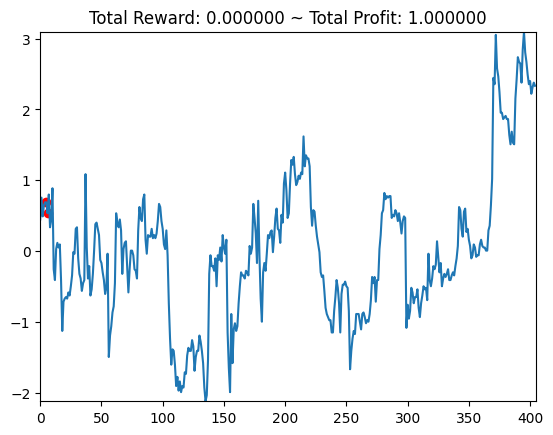

AssertionError: High FPS! Try to reduce the 'render_fps' value.

In [23]:
env = gym.make('forex-v0', df=forex_df, window_size=5, frame_bound=[100, 500])

observation = env.reset()
while True:
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
# 
    env.render()
    if done:
        print("info:", info,observation )
        break

plt.cla()
env.unwrapped.render_all()
plt.show()

In [24]:
print("env information:")
print("> shape:", env.unwrapped.shape)
print("> df.shape:", env.unwrapped.df.shape)
print("> prices.shape:", env.unwrapped.prices.shape)
print("> signal_features.shape:", env.unwrapped.signal_features.shape)
print("> max_possible_profit:", env.unwrapped.max_possible_profit())


env information:
> shape: (5, 7)
> df.shape: (11961, 6)
> prices.shape: (405,)
> signal_features.shape: (405, 7)
> max_possible_profit: 0.00250234906987181


In [25]:
env.action_space

Discrete(3)

### Build Environment and Train

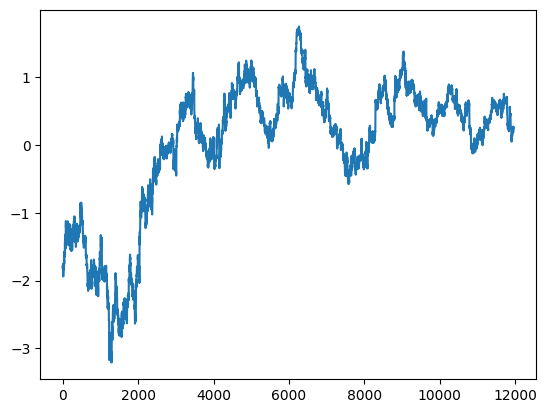

In [26]:
env_maker = lambda: gym.make('forex-v0', df=forex_df, frame_bound=(5,len(forex_df)), window_size=5)
env = DummyVecEnv([env_maker])


Using cpu device
-----------------------------
| time/              |      |
|    fps             | 1209 |
|    iterations      | 1    |
|    time_elapsed    | 1    |
|    total_timesteps | 2048 |
-----------------------------
-----------------------------------------
| time/                   |             |
|    fps                  | 816         |
|    iterations           | 2           |
|    time_elapsed         | 5           |
|    total_timesteps      | 4096        |
| train/                  |             |
|    approx_kl            | 0.010286028 |
|    clip_fraction        | 0.0998      |
|    clip_range           | 0.2         |
|    entropy_loss         | -1.09       |
|    explained_variance   | 0.000146    |
|    learning_rate        | 0.001       |
|    loss                 | 2.61e+05    |
|    n_updates            | 10          |
|    policy_gradient_loss | -0.00653    |
|    value_loss           | 4.97e+05    |
-----------------------------------------
Eval num_timestep

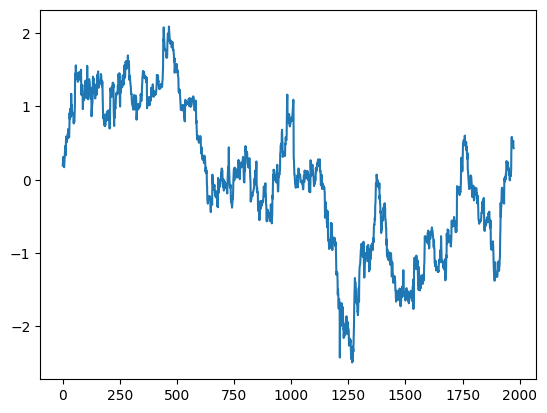

In [27]:
# Callbacks for monitoring and saving
checkpoint_callback = CheckpointCallback(save_freq=10000, save_path='./models/', name_prefix='ppo_forex')
env_maker = lambda: gym.make('forex-v0', df=forex_df, frame_bound=(30,2000), window_size=5)
eval_env = DummyVecEnv([env_maker])
eval_callback = EvalCallback(eval_env, best_model_save_path='./logs/', log_path='./logs/', eval_freq=5000, deterministic=True)

# List of callbacks
callback = CallbackList([checkpoint_callback, eval_callback])

# Train the model
# with mlflow.start_run():
model = PPO('MlpPolicy', env, verbose=1,
    learning_rate=0.001,      # Slightly lower learning rate for stability
# n_steps=1024,              # Keep as is, but can experiment with 1024 or 4096
# batch_size=64,             # Keep as is, but can experiment with 32 or 128
# n_epochs=10,               # Keep as is, but can experiment with 5 or 20
gamma=0.99,                # Higher discount factor to consider future rewards more
# gae_lambda=0.95,           # Keep as is, but can experiment with 0.9 to 1.0
# clip_range=0.2,            # Keep as is, but can experiment with 0.1 to 0.3
# ent_coef=0.02,             # Slightly higher entropy coefficient for more exploration
# vf_coef=0.5,               # Keep as is, but can experiment with 0.2 to 1.0
# max_grad_norm=0.5          # Keep as is, but can experiment with 0.5 to 1.0
) 
# Set custom logger
# model.set_logger(loggers)
model.learn(total_timesteps=4000000,log_interval=1, callback=callback)


In [138]:
model_name = "trader_usd_eur_ppo"

In [139]:
model.save(model_name)

### Evaluation

INFO:root:Updated profit: 0.9063634060332235
INFO:root:Updated profit: 0.9063634060332235
INFO:root:Updated profit: 0.6496175201611974
INFO:root:Updated profit: 0.6496175201611974
INFO:root:Updated profit: 2.2145532847261773
INFO:root:Updated profit: 2.2145532847261773
INFO:root:Updated profit: 0.4104901323867717
INFO:root:Updated profit: 0.4104901323867717
INFO:root:Updated profit: -0.04557949138932185
INFO:root:Updated profit: -0.04557949138932185
INFO:root:Updated profit: -0.06290844759741311
INFO:root:Updated profit: -0.06290844759741311
INFO:root:Updated profit: -0.12094557733826469
INFO:root:Updated profit: -0.12094557733826469
INFO:root:Updated profit: 0.0811583963055751
INFO:root:Updated profit: 0.0811583963055751
INFO:root:Updated profit: 0.01471315672720453


info: {'total_reward': 24344.456905156374, 'total_profit': 0.01471315672720453, 'position': <Positions.Short: 0>} [[1.9777821 1.6539327 1.2078769 1.1631104 1.7939239 1.4940124 1.191516 ]
 [1.9870995 1.6804731 1.2108783 1.1814321 1.8430374 1.504421  1.1852682]
 [2.043015  1.7053645 1.2132524 1.2935312 1.8957784 1.5118766 1.19212  ]
 [1.8940456 1.7261866 1.217502  0.6854907 1.9217918 1.539851  1.1072394]
 [1.8754545 1.7480514 1.2218282 0.6144437 1.9378791 1.5867299 1.016311 ]]


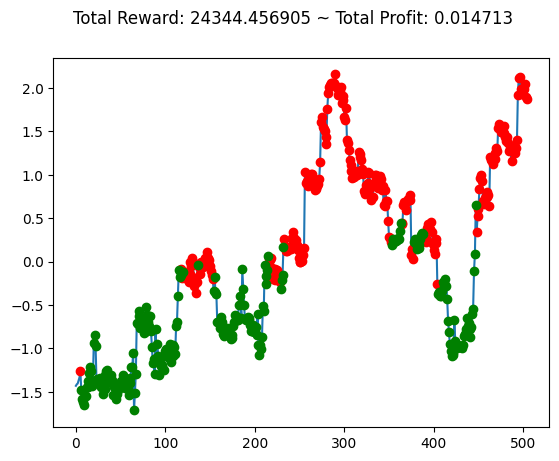

In [140]:
# Initialize the gym environment and your model as usual
env = gym.make('forex-v0', df=forex_df, frame_bound=(1500, 2000), window_size=5)
obs, _ = env.reset()
del model

# Load the trained model
model = PPO.load(model_name)

# Turn on interactive plotting
plt.ion()

while True:
    action, _states = model.predict(obs)
    obs, reward, terminated, truncated, info = env.step(action)
    done = terminated or truncated
    # env.render()
    # plt.pause(0.01)  # Pause to allow the plot to update
    if done:
        print("info:", info, obs)
        break

# Turn off interactive plotting and show the final plot
plt.cla()
env.unwrapped.render_all()
plt.show()

In [141]:
del model

# Load the trained model
model = DQN.load("trader_usd_eur_dqn_2")

# Initialize the environment
# env = ForexEnv(df, window_size=50)
obs = env.reset()

# Run the model to get predictions and interact with the environment
for i in range(len(df) - env.unwrapped.window_size - 1):
    # deterministic=True
    action, _states = model.predict(obs)
    obs, reward, done, _ = env.step(action)  # Extract only required values
    if done:
        break

# After the loop, analyze the action distribution
# action_counts = {action: 0 for action in range(env.action_space.n)}
# for action in model.actions_taken:
#     action_counts[action] += 1
# print("Action distribution:", action_counts)


FileNotFoundError: [Errno 2] No such file or directory: 'trader_usd_eur_dqn_2.zip'

In [ ]:
import oandapyV20
import oandapyV20.endpoints.pricing as pricing
import oandapyV20.endpoints.orders as orders
import oandapyV20.endpoints.instruments as instruments
import pandas as pd
import logging
from oandapyV20 import API
import json
from oandapyV20.exceptions import V20Error
from oandapyV20.endpoints.pricing import PricingStream
from oandapyV20.endpoints.pricing import PricingStream
from oandapyV20.endpoints.orders import OrderCreate
from oandapyV20.contrib.factories import InstrumentsCandlesFactory
from oandapyV20.contrib.requests import MarketOrderRequest
from oandapyV20.contrib.requests import TakeProfitDetails, StopLossDetails

In [0]:
# OANDA API credentials
access_token = "0922675609ea57cff543c8c7a74bf72c-b080b89522fd436a7c5e3809137c48f1"
account_id ="101-004-29270068-001"
client = API(access_token=access_token)

In [0]:
import gym
import matplotlib.pyplot as plt
import logging
import pandas as pd
import numpy as np
from stable_baselines3 import A2C
from stable_baselines3.common.envs import DummyVecEnv

# Initialize environment
env = gym.make('forex-v0', frame_bound=(100, 500), window_size=5)
env = DummyVecEnv([lambda: env])

# Load pre-trained model
model = A2C.load('trader_usd_eur_a2c')

# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s:%(message)s')

# Initialize historical data
data = {}

# Function to fetch historical data (optional, depending on your setup)
def fetch_historical_data(instrument, count, granularity):
    params = {"count": count, "granularity": granularity}
    try:
        request = instruments.InstrumentsCandles(instrument=instrument, params=params)
        candles = client.request(request)["candles"]
        df = pd.DataFrame([{'time': c['time'], 'close': c['mid']['c']} for c in candles])
        df['time'] = pd.to_datetime(df['time'])
        df.set_index('time', inplace=True)
        return df
  
    except Exception as e:
        logging.error(f"Error fetching historical data for {instrument}: {e}")
        return None

# Function to place an order
def place_order(instrument, units, stop_loss_pips=50, take_profit_pips=100):
    try:
        price = float(data[instrument].iloc[-1]["close"])
        stop_loss_price = price - (stop_loss_pips * 0.0001 * units / abs(units))
        take_profit_price = price + (take_profit_pips * 0.0001 * units / abs(units))

        order = {
            "order": {
                "instrument": instrument,
                "units": str(units),
                "type": "MARKET",
                "positionFill": "DEFAULT",
                "stopLossOnFill": {
                    "price": str(stop_loss_price)
                },
                "takeProfitOnFill": {
                    "price": str(take_profit_price)
                }
            }
        }
        request = OrderCreate(accountID=account_id, data=order)
        response = client.request(request)
        logging.info(f"Order placed for {instrument}: {response}")

    except Exception as e:
        logging.error(f"Error placing order for {instrument}: {e}")

# Stream data and apply model's prediction for trading
def stream_data_and_trade(instruments):
    params = {"instruments": ",".join(instruments)}
    priceStream = PricingStream(accountID=account_id, params=params)
    try:
        for tick in client.request(priceStream):
            if tick['type'] == 'PRICE':
                instrument = tick['instrument']
                price = (float(tick['bids'][0]['price']) + float(tick['asks'][0]['price'])) / 2

                if instrument not in data:
                    data[instrument] = fetch_historical_data(instrument, count=300, granularity="M30")
                    if data[instrument] is None:
                        continue

                df = data[instrument]

                # Update the DataFrame with the new tick data
                new_row = pd.DataFrame({"time": [pd.to_datetime(tick['time'])], "close": [price]})
                new_row.set_index("time", inplace=True)
                df = pd.concat([df, new_row])
                if len(df) > 300:
                    df = df.iloc[-300:]  # Keep only the last 300 rows
                data[instrument] = df

                # Prepare observation for the model
                obs = df["close"].values[-env.observation_space.shape[0]:]
                obs = obs[np.newaxis, ..., np.newaxis]  # Adjust shape for model input

                # Model prediction
                action, _states = model.predict(obs)

                # Translate model action to buy/sell decision
                units = 1000 if action == 1 else -1000 if action == 2 else 0  # Assuming 0: hold, 1: buy, 2: sell

                if units != 0:
                    place_order(instrument, units)

    except V20Error as e:
        logging.error(f"Error streaming data: {e}")

# Start streaming data and trading  "GBP_USD", "EUR_JPY"
instruments = ["EUR_USD"]
stream_data_and_trade(instruments)

# # Setup logging
# logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s:%(message)s')

# # Function to fetch historical data (optional, depending on your setup)
# def fetch_historical_data(instrument, count, granularity):
#     params = {"count": count, "granularity": granularity}
#     try:
#         request = instruments.InstrumentsCandles(instrument=instrument, params=params)
#         candles = client.request(request)["candles"]
#         df = pd.DataFrame([{'time': c['time'], 'close': c['mid']['c']} for c in candles])
#         df['time'] = pd.to_datetime(df['time'])
#         df.set_index('time', inplace=True)
#         return df
  
#     except Exception as e:
#         logging.error(f"Error fetching historical data for {instrument}: {e}")
#         return None

# # Function to place an order
# def place_order(instrument, units, stop_loss_pips=50, take_profit_pips=100):
#     try:
#         price = float(data[instrument].iloc[-1]["close"])
#         stop_loss_price = price - (stop_loss_pips * 0.0001 * units / abs(units))
#         take_profit_price = price + (take_profit_pips * 0.0001 * units / abs(units))

#         order = {
#             "order": {
#                 "instrument": instrument,
#                 "units": str(units),
#                 "type": "MARKET",
#                 "positionFill": "DEFAULT",
#                 "stopLossOnFill": {
#                     "price": str(stop_loss_price)
#                 },
#                 "takeProfitOnFill": {
#                     "price": str(take_profit_price)
#                 }
#             }
#         }
#         request = OrderCreate(accountID=account_id, data=order)
#         response = client.request(request)
#         logging.info(f"Order placed for {instrument}: {response}")

#     except Exception as e:
#         logging.error(f"Error placing order for {instrument}: {e}")

# # Stream data and apply model's prediction for trading
# def stream_data_and_trade(instruments):
#     params = {"instruments": ",".join(instruments)}
#     priceStream = PricingStream(accountID=account_id, params=params)
#     try:
#         for tick in client.request(priceStream):
#             if tick['type'] == 'PRICE':
#                 instrument = tick['instrument']
#                 price = (float(tick['bids'][0]['price']) + float(tick['asks'][0]['price'])) / 2

#                 if instrument not in data:
#                     data[instrument] = fetch_historical_data(instrument, count=300, granularity="M30")
#                     if data[instrument] is None:
#                         continue

#                 df = data[instrument]

#                 # Update the DataFrame with the new tick data
#                 new_row = pd.DataFrame({"time": [pd.to_datetime(tick['time'])], "close": [price]})
#                 new_row.set_index("time", inplace=True)
#                 df = pd.concat([df, new_row])
#                 if len(df) > 300:
#                     df = df.iloc[-300:]  # Keep only the last 300 rows
#                 data[instrument] = df

#                 # Prepare observation for the model
#                 obs = df["close"].values[-env.observation_space.shape[0]:]
#                 obs = obs[np.newaxis, ..., np.newaxis]  # Adjust shape for model input

#                 # Model prediction
#                 action, _states = model.predict(obs)

#                 # Translate model action to buy/sell decision
#                 units = 1000 if action == 1 else -1000 if action == 2 else 0  # Assuming 0: hold, 1: buy, 2: sell

#                 if units != 0:
#                     place_order(instrument, units)

#     except V20Error as e:
#         logging.error(f"Error streaming data: {e}")

# # Start streaming data and trading
# instruments = ["EUR_USD", "GBP_USD", "EUR_JPY"]
# stream_data_and_trade(instruments)


In [0]:
# Setup logging
logging.basicConfig(level=logging.INFO, format='%(asctime)s %(levelname)s:%(message)s')

# Parameters
instruments_list = ["DE30_EUR", "EUR_USD", "EUR_JPY"]
params = {"instruments": ",".join(instruments_list)}
short_window = 50
long_window = 200
# Initialize historical data
data = {}

# Function to fetch historical data
def fetch_historical_data(instrument, count, granularity):
    params = {"count": count, "granularity": granularity}
    try:
        request = instruments.InstrumentsCandles(instrument=instrument, params=params)
        candles = client.request(request)["candles"]
        print(candles)
  
  
    except Exception as e:
        logging.error(f"Error fetching historical data for {instrument}: {e}")
        return None

# Function to apply the trading strategy
def apply_strategy(df, short_window, long_window):
    df["SMA_short"] = df["close"].rolling(window=short_window).mean()
    df["SMA_long"] = df["close"].rolling(window=long_window).mean()
    df["signal"] = 0.0
    df.loc[df.index[short_window:], "signal"] = (df["SMA_short"][short_window:] > df["SMA_long"][short_window:]).astype(float)
    df["positions"] = df["signal"].diff()
    return df

# Function to place an order
def place_order(instrument, units, stop_loss_pips=50, take_profit_pips=100):
    try:
        price = float(data[instrument].iloc[-1]["close"])
        stop_loss_price = price - (stop_loss_pips * 0.0001 * units / abs(units))
        take_profit_price = price + (take_profit_pips * 0.0001 * units / abs(units))

        order = {
            "order": {
                "instrument": instrument,
                "units": str(units),
                "type": "MARKET",
                "positionFill": "DEFAULT",
                "stopLossOnFill": {
                    "price": str(stop_loss_price)
                },
                "takeProfitOnFill": {
                    "price": str(take_profit_price)
                }
            }
        }
        request = OrderCreate(accountID=account_id, data=order)
        response = client.request(request)
        logging.info(f"Order placed for {instrument}: {response}")

    except Exception as e:
        logging.error(f"Error placing order for {instrument}: {e}")
        
# Stream data and apply strategy
def stream_data_and_trade(instruments):
    params = {"instruments": ",".join(instruments)}
    priceStream = PricingStream(accountID=account_id, params=params)
    try:
        for tick in client.request(priceStream):
            if tick['type'] == 'PRICE':
                instrument = tick['instrument']
                price = (float(tick['bids'][0]['price']) + float(tick['asks'][0]['price'])) / 2

                if instrument not in data:
                    data[instrument] = fetch_historical_data(instrument, count=300, granularity="M30")
                    if data[instrument] is None:
                        continue

                df = data[instrument]

                # Update the DataFrame with the new tick data
                new_row = pd.DataFrame({"time": [pd.to_datetime(tick['time'])], "close": [price]})
                new_row.set_index("time", inplace=True)
                df = pd.concat([df, new_row])
                if len(df)> 300:
                    df = df.iloc[-300:]  # Keep only the last 300 rows
                data[instrument] = df

                # Apply trading strategy
                df = apply_strategy(df, short_window, long_window)

                # Check for buy/sell signals
                last_row = df.iloc[-1]
                if last_row["positions"] == 1:
                    place_order(instrument, 10)
                elif last_row["positions"] == -1:
                    place_order(instrument, -10)
                else:
                    logging.info(f"Order not placed for any instrument")

    except V20Error as e:
        logging.error(f"Error streaming data: {e}")


instruments = ["EUR_USD","GBP_USD"]
# Start streaming data and trading
stream_data_and_trade(instruments)

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=3d45628e-a0f9-421e-94f2-273c0d2863ec' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>